### Basics of filtering

Filtering here is defined as a convolution. For functions on R it can be written as : 

$$
f_l(x) = \int G_l(x - y) f(y) dy
$$
where $G(x)$ is a normalized kernel, $\int G(x) dx = 1$ and $G_l (x) = \frac{1}{l} G(x/l)$. 

It can also be shown that for the spectrum: 
$$
|F_l [k]|^2 = |G[lk]|^2 . |F[k]|^2. 
$$
This means that the spectrum of the filtered function is the weighted spectrum of the original function, where the weights correspond to the spectrum of the filter. 


In [1]:
import numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt

In [2]:
# A function with a given spectrum and resolution 

def random_phase_power_law_function(alpha, N, L=2*np.pi):
    '''
    Returns a periodic signal generated with a specified
    energy spectrum.
    '''
    
    #L = 2*np.pi
    #N = 128 # Change N to change resolution of the signal
    
    dx = L/N

    n = np.arange(0, N)
    x = n*dx
    k = np.arange(0, N) # all ks
    
    inc_k = slice(1, int(N/2)) # only ks for positive frequencies
    k_positive = k[inc_k] # The case for even
    k_positive_units = k_positive/ N /dx
    
    k_smallest = k_positive_units[0]
    k_break = k_smallest*5 # where slope break is

    fhat_random_phase =np.zeros_like(k).astype(np.complex128)

    Ek = np.zeros_like(k_positive_units)

    #alpha = 2. # power law slope

    C = 1/ (k_break**(-alpha)) # matching coeff.

    Ek[k_positive_units<=k_break] = 1.
    Ek[k_positive_units>k_break] = C*k_positive_units[k_positive_units>k_break]**(-alpha) # Note that the energy spectrum is square of fhat

    random_theta = np.random.uniform(low=0, high=2*np.pi, size=(len(Ek),))

    fhat_random_phase[inc_k] = Ek**0.5 * np.exp(1j*random_theta)

    # Set negative freq to be the same
    fhat_random_phase[-1: - int(N/2): -1] = np.conjugate(fhat_random_phase[inc_k])
    
    f_gen1 = fft.ifft(N*fhat_random_phase)
    
    return f_gen1.real, x, dx
    

In [3]:
L = 1000 # let's say units of m 
N=128
f, x, dx = random_phase_power_law_function(2, N, L)

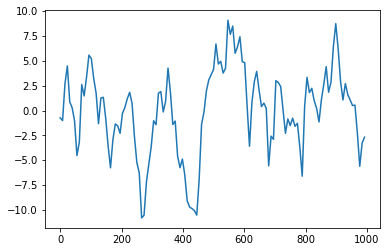

In [4]:
plt.plot(x, f)

In [5]:
def power_spectrum(y, dx): 
    '''
    Computes power spectrum of some signal,
    and the spacing dx allows one to determine the 
    corresponding frequencies in the right units [1/m].
    '''
    N = len(y)
    fft_freq = fft.fftfreq(N, d = dx) 
    
    yhat = fft.fft(y)
    
    inc_k = slice(1, int(N/2)) 
    yhat = yhat[inc_k]
    fft_freq = fft_freq[inc_k]
    
    return ((np.abs(yhat)/N )**2), fft_freq

In [6]:
f_ps, k = power_spectrum(f, dx)

(0.005, 2)

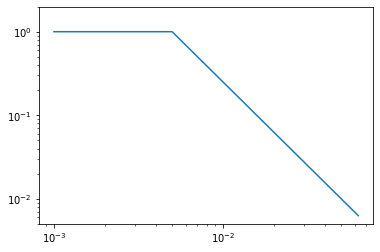

In [7]:
plt.plot(k, f_ps)
plt.plot(k, k**-2, 'k--')
plt.xscale('log')
plt.yscale('log')

plt.ylim([5e-3, 2])

#### Filtering

In [8]:
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage.filters import convolve1d

The kernel is defined here: https://github.com/scipy/scipy/blob/v1.9.3/scipy/ndimage/_filters.py#L179

This is essentially a truncated gaussian function. The default is to truncate at $4 \sigma$ in each direction. Everything is handled by default in units of number of grid points (dx =1). 

In [9]:
def top_hat_kernel(width, radius):
    """
    Computes a 1D Gaussian convolution kernel.
    """
    x = np.arange(-radius, radius + 1) # define the range over which we need the values, +1  because of weird functionality of arange
    
    phi_x = 0.*x
    phi_x[abs(x)<=width/2] = 1./width
    
    # normalization
    phi_x /= phi_x.sum()
    
    return phi_x

def gaussian_kernel(sigma, radius):
    """
    Computes a 1D Gaussian convolution kernel.
    """
    
    p = np.polynomial.Polynomial([0, 0, -0.5 / (sigma * sigma)])
    
    x = np.arange(-radius, radius + 1)
    
    # E^(p(x))
    phi_x = np.exp(p(x), dtype=np.double)
    
    # normalization
    phi_x /= phi_x.sum()
        
    return phi_x

In [10]:
def my_filter1d(f, sigma, kernel, mode='wrap', truncate=4.0):
    """ wrapper function for convolve"""
    lw = int(truncate * float(sigma) + 0.5)
    weights = kernel(sigma, lw)
    
    return convolve1d(f, weights, mode = mode)

In [124]:
lfilter = 11*dx # units of m 
# we use odd units of dx for filter scale, as it works best for
# the top-hat filter -as we describe later. 

sigmafilter = lfilter / np.sqrt(12) 
# This sqrt(12) comes from computing the standard deviation of
# a box car filter with width l.
nfilter_gauss = sigmafilter/dx
nfilter_tophat = lfilter/dx

### Filter shapes and spectra 

In [125]:
f_hat = top_hat_kernel(nfilter_tophat, N/2-1)
f_gauss = gaussian_kernel(nfilter_gauss, N/2-1)

Text(0.5, 0, '[m]')

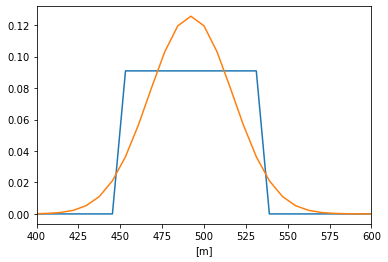

In [126]:
plt.plot(x[:-1], f_hat)
plt.plot(x[:-1], f_gauss)
plt.xlim([400, 600])
plt.xlabel('[m]')

In [127]:
f_hat_ps, k_filt = power_spectrum(f_hat, dx)
f_gauss_ps, k_filt = power_spectrum(f_gauss, dx)

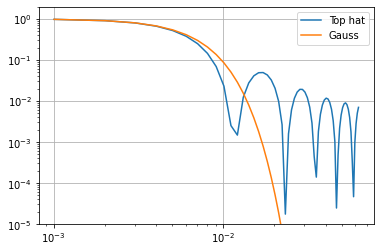

In [128]:
plt.plot(k_filt, (N-1)**2*f_hat_ps, label = 'Top hat')
plt.plot(k_filt, (N-1)**2*f_gauss_ps, label = 'Gauss')
# We multiply by N-1 to recover the term that multiplies the fft

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.ylim([1e-5, 2])
plt.grid()

#### Back to filtering

In [129]:
f_l_scipygauss = gaussian_filter1d(f, nfilter_gauss, mode='wrap')
f_l_gauss = my_filter1d(f, nfilter_gauss, gaussian_kernel,   mode='wrap')
f_l_tophat = my_filter1d(f, nfilter_tophat, top_hat_kernel,   mode='wrap')

In [163]:
dx, nfilter_gauss, nfilter_tophat

(7.8125, 3.175426480542942, 13.0)

Text(0.5, 0, 'x [m]')

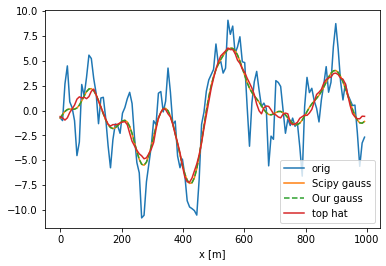

In [131]:
plt.plot(x, f, label='orig')
plt.plot(x, f_l_scipygauss, label='Scipy gauss')
plt.plot(x, f_l_gauss, '--', label='Our gauss')
plt.plot(x, f_l_tophat, label='top hat')

plt.legend()
plt.xlabel('x [m]')

Compare the power spectra

In [132]:
f_l_scipygauss_ps, k = power_spectrum(f_l_scipygauss, dx)
f_l_gauss_ps, k = power_spectrum(f_l_gauss, dx)
f_l_tophat_ps, k = power_spectrum(f_l_tophat, dx)

(1e-05, 2)

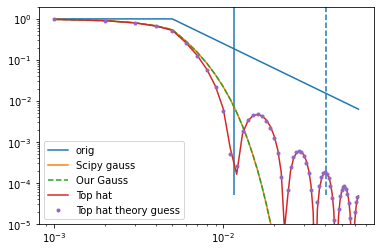

In [133]:
plt.plot(k, f_ps, label = 'orig')

plt.plot(k, f_l_scipygauss_ps, label = 'Scipy gauss')
plt.plot(k, f_l_gauss_ps, '--', label = 'Our Gauss')
plt.plot(k, f_l_tophat_ps, label = 'Top hat')

plt.plot(k[:-1], f_ps[:-1]*(N-1)**2*f_hat_ps, '.', label = 'Top hat theory guess')

plt.vlines([1/lfilter],5e-5, 2)
plt.vlines([1/sigmafilter],5e-5, 2, linestyles='--')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.ylim([1e-5, 2])

- As expected the filtering reduces the power at smaller scales (larger frequencies).
- The change in spectra due to gauss and top hat are similar, but not the same. 
- Meaning of filter scale is a bit arbitrary. Even the match between gaussian and top hat was based on arbitrary choice. 
- (Amazingly!) the theoretical guess for the top hat filter works really well. 
- The filter scale passes right through where the first corner for the top-hat filter is, which is where the first zero-crossing is for the fourier coefficients of top-hat. 


#### Some futher comments on the top hat filter 

In [158]:
lfilter = 13*dx # units of m
nfilter_tophat = lfilter/dx

In [174]:
sigmafilter = lfilter / np.sqrt(12) 
# This sqrt(12) comes from computing the standard deviation of
# a box car filter with width l.
nfilter_gauss = sigmafilter/dx

Top-hat filter is defined in a discrete sense, and so many filter scale appear the same to it. Even when we define it in terms of dx, the odd and even filters are the same (filter sacle of 10*dx and 11*dx are the same). Having the filter scale be an odd number works well, with even number there is a little ambiguity as half steps can't be handled. 

We can maybe deal with this more carefully if need be, but hopefully won't really be an issue for more continuous filters (like the graded top hat). 

In [175]:
f_hat_test = top_hat_kernel(nfilter_tophat, N/2-1)

In [176]:
f_gauss_test = gaussian_kernel(nfilter_gauss, N/2-1)

In [177]:
top_hat_fft = fft.fft(np.roll(f_hat_test, int(N/2 )) )
gauss_fft = fft.fft(np.roll(f_gauss_test, int(N/2 )) )
k_filter = fft.fftfreq(len(f_hat_test), d=dx)

In [178]:
top_hat_fft[0], gauss_fft[0]
# The normalization of filters needs to be such that 
# the zeroth FFT component is 1. 

((1-0j), (1-0j))

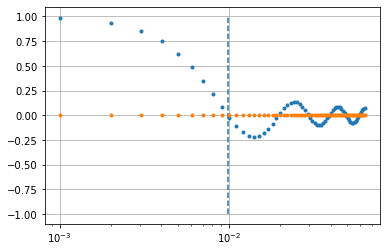

In [179]:
plt.plot(k_top_hat_fft, np.real(top_hat_fft), '.')

plt.plot(k_top_hat_fft, np.imag(top_hat_fft), '.')

plt.vlines(1/lfilter, -1, 1, linestyles='--')
plt.grid()

plt.xscale('log')

The above figure shows the characteristic sinc shape for the FFT of a top hat filter. The first zero crossing (marked by vertical line) is defined as the length scale.

The figure below shows how the fft of the top hat and gaussian compare.

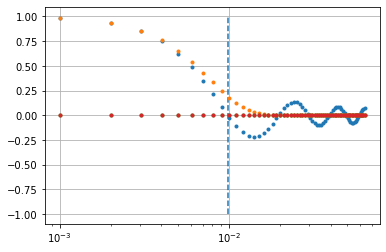

In [180]:
plt.plot(k_top_hat_fft, np.real(top_hat_fft), '.')
plt.plot(k_top_hat_fft, np.real(gauss_fft), '.')

plt.plot(k_top_hat_fft, np.imag(top_hat_fft), '.')
plt.plot(k_top_hat_fft, np.imag(gauss_fft), '.')


plt.vlines(1/lfilter, -1, 1, linestyles='--')
plt.grid()

plt.xscale('log')

#### Van der ven filters
Find another notebook to understand how these filters are defined and how they are different. 

Here we copy over the main functions, and do similar analysis to what is above but for the VDV filters. 

In [189]:
def Ghat(k, m, sigma=1.):
     return np.exp( -1 / (2*m) * (k**(2*m)) * 
                    (2*np.pi*sigma)**(2*m) )
    
def G_m(sigma, radius, m=1.):
    """
    Computes a 1D Van der ven kernel
    
    Everything is in grid point units 
    """
    
    x = np.arange(-radius, radius+1)
    N = len(x)
    k = fft.fftfreq(N)
    
    Ghat_m = Ghat(k, m, sigma)
    
    G_m = np.roll( fft.ifft(Ghat_m), int ((N-1)/2)) 
    
    return G_m , x 

In [190]:
# Define this agiain because we need to pass additional options.
def my_filter1d_vdv(f, sigma, kernel, m=1, mode='wrap', truncate=4.0):
    """ wrapper function for convolve"""
    lw = int(truncate * float(sigma) + 0.5)
    weights,_ = kernel(sigma, lw, m)
    
    return convolve1d(f, weights, mode = mode)

In [205]:
f_l_gauss = my_filter1d(f, nfilter_gauss, gaussian_kernel,   mode='wrap')
f_l_gm1 = my_filter1d_vdv(f, nfilter_gauss, G_m,  m=1, mode='wrap', truncate=4.)
f_l_gm2 = my_filter1d_vdv(f, nfilter_gauss, G_m,  m=2, mode='wrap', truncate=4.)
f_l_gm3 = my_filter1d_vdv(f, nfilter_gauss, G_m,  m=3, mode='wrap', truncate=4.)
#f_l_tophat = my_filter1d(f, nfilter_tophat, top_hat_kernel,   mode='wrap')

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/scipy/ndimage/filters.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  weights = numpy.asarray(weights, dtype=numpy.float64)


Text(0.5, 0, 'x [m]')

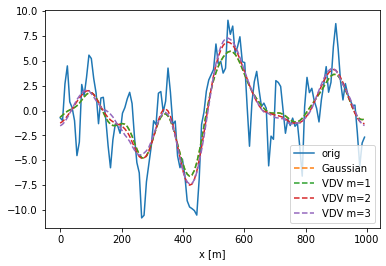

In [206]:
plt.plot(x, f, label='orig')
plt.plot(x, f_l_gauss, '--', label='Gaussian')
plt.plot(x, f_l_gm1, '--', label='VDV m=1')
plt.plot(x, f_l_gm2, '--', label='VDV m=2')
plt.plot(x, f_l_gm3, '--', label='VDV m=3')
#plt.plot(x, f_l_tophat, label='top hat')

plt.legend()
plt.xlabel('x [m]')

In [207]:
f_l_gauss_ps, k = power_spectrum(f_l_gauss, dx)
f_l_gm1_ps, k = power_spectrum(f_l_gm1, dx)
f_l_gm2_ps, k = power_spectrum(f_l_gm2, dx)
f_l_gm3_ps, k = power_spectrum(f_l_gm3, dx)

(1e-06, 2)

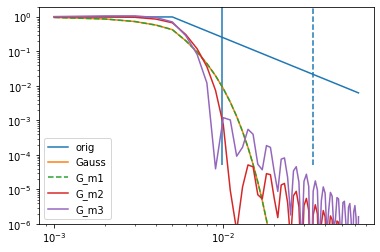

In [208]:
plt.plot(k, f_ps, label = 'orig')

plt.plot(k, f_l_gauss_ps,  label = 'Gauss')
plt.plot(k, f_l_gm1_ps, '--', label = 'G_m1')
plt.plot(k, f_l_gm2_ps, label = 'G_m2')
plt.plot(k, f_l_gm3_ps, label = 'G_m3')


plt.vlines([1/lfilter],5e-5, 2)
plt.vlines([1/sigmafilter],5e-5, 2, linestyles='--')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.ylim([1e-6, 2])

Some notes: 
- We applied the VDV filters in real space (good job!)
- For m = 1, we get the exact gaussian filter
- Higher order filters needs the truncate option to be larger, as the tails are not well resolved for lower truncate. 
- Visually the differences are not that dramatic when the field is filtered using the different filters. 